In [1]:
import pandas as pd

# 1. load the dataset
df = pd.read_csv("cars.csv")

# 2. show first 5 rows so to confirm columns + formatting
print("HEAD ========================")
display(df.head())

# 3. show column names
print("\nCOLUMNS =====================")
print(df.columns.tolist())

# 4. show number of rows
print("\nSHAPE =======================")
print(df.shape)

# 5. quick info about data types
print("\nINFO ========================")
print(df.dtypes)


HEAD ========================


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0



COLUMNS =====================
['name', 'year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque', 'seats']

SHAPE =======================
(8128, 13)

INFO ========================
name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object


In [2]:
import numpy as np

df_clean = df.copy()  # keep original df safe; work on a cleaned copy

# drop rows where the target 'selling_price' is missing
# (you can't train a regression model if you don't know the true price)
df_clean = df_clean.dropna(subset=["selling_price"])

# convert messy string columns like "23.4 kmpl", "1248 CC", "74 bhp" into pure numbers
def extract_number(series):
    def to_num(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            return x
        s = str(x).strip()
        first = s.split()[0].replace(",", "")  # keep only the numeric part before the unit
        try:
            return float(first)
        except:
            return np.nan
    return series.apply(to_num)

# create cleaned numeric features for mileage/engine/power so the model can actually use them
df_clean["mileage_num"] = extract_number(df_clean["mileage"])
df_clean["engine_cc"] = extract_number(df_clean["engine"])
df_clean["max_power_bhp"] = extract_number(df_clean["max_power"])

# remove extreme outlier cars (top 1% most expensive)
# this prevents rare super-luxury prices from blowing up the model
q99 = df_clean["selling_price"].quantile(0.99)
df_clean = df_clean[df_clean["selling_price"] <= q99]

# choose which columns to feed into the model
# numeric_cols = continuous numbers (age, mileage, power, etc.)
# categorical_cols = text categories (fuel type, transmission, etc.) to encode 
numeric_cols_we_expect = [
    "year",
    "km_driven",
    "mileage_num",
    "engine_cc",
    "max_power_bhp",
    "seats",
]

categorical_cols_we_expect = [
    "name",
    "fuel",
    "seller_type",
    "transmission",
    "owner",
]

# keep only columns that actually exist in this file in case some col missing
numeric_cols = [c for c in numeric_cols_we_expect if c in df_clean.columns]
categorical_cols = [c for c in categorical_cols_we_expect if c in df_clean.columns]

feature_cols = numeric_cols + categorical_cols

# X = features we use to predict price
# y = target price ('selling_price')
X = df_clean[feature_cols].copy()
y = df_clean["selling_price"].copy()

print("After cleaning/outlier removal:")
print("Shape:", df_clean.shape)

print("\nNumeric columns used:")
print(numeric_cols)

print("\nCategorical columns used:")
print(categorical_cols)

print("\nPreview of X (features):")
display(X.head())

print("\nPreview of y (target):")
print(y.head())

After cleaning/outlier removal:
Shape: (8049, 16)

Numeric columns used:
['year', 'km_driven', 'mileage_num', 'engine_cc', 'max_power_bhp', 'seats']

Categorical columns used:
['name', 'fuel', 'seller_type', 'transmission', 'owner']

Preview of X (features):


,year,km_driven,mileage_num,engine_cc,max_power_bhp,seats,name,fuel,seller_type,transmission,owner
0,2014,145500,23.40,1248.0,74.00,5.0,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
1,2014,120000,21.14,1498.0,103.52,5.0,Skoda Rapid 1.5 TDI Ambition,Diesel,Individual,Manual,Second Owner
2,2006,140000,17.70,1497.0,78.00,5.0,Honda City 2017-2020 EXi,Petrol,Individual,Manual,Third Owner
3,2010,127000,23.00,1396.0,90.00,5.0,Hyundai i20 Sportz Diesel,Diesel,Individual,Manual,First Owner
4,2007,120000,16.10,1298.0,88.20,5.0,Maruti Swift VXI BSIII,Petrol,Individual,Manual,First Owner



Preview of y (target):
0    450000
1    370000
2    158000
3    225000
4    130000
Name: selling_price, dtype: int64


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2) Preprocess: numeric -> impute median + scale
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# 3) Preprocess: categorical -> impute most_frequent + one-hot
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# 4) Combine into a ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ]
)

# ============================
# MODEL A: Random Forest
# ============================
rf_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42
    ))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mae  = mean_absolute_error(y_test, rf_pred)
rf_mse  = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2   = r2_score(y_test, rf_pred)

print("=== RANDOM FOREST REGRESSOR (Traditional ML) ===")
print(f"MAE : {rf_mae:.4f}")
print(f"MSE : {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"R^2 : {rf_r2:.4f}")

# ============================
# MODEL B: MLP Regressor (Neural/Deep)
# ============================
mlp_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        solver="adam",
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])

mlp_model.fit(X_train, y_train)
mlp_pred = mlp_model.predict(X_test)

mlp_mae  = mean_absolute_error(y_test, mlp_pred)
mlp_mse  = mean_squared_error(y_test, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2   = r2_score(y_test, mlp_pred)

print("\n=== MLP REGRESSOR (Neural / Deep Model) ===")
print(f"MAE : {mlp_mae:.4f}")
print(f"MSE : {mlp_mse:.4f}")
print(f"RMSE: {mlp_rmse:.4f}")
print(f"R^2 : {mlp_r2:.4f}")

# ============================
# Simple comparison by RMSE
# ============================
better_model = "Random Forest" if rf_rmse < mlp_rmse else "MLP Neural Net"
print(f"\n=> Better RMSE: {better_model}")


=== RANDOM FOREST REGRESSOR (Traditional ML) ===
MAE : 68384.9483
MSE : 18278928173.4354
RMSE: 135199.5864
R^2 : 0.9596

=== MLP REGRESSOR (Neural / Deep Model) ===
MAE : 85356.7634
MSE : 31216940912.3849
RMSE: 176683.1653
R^2 : 0.9311

=> Better RMSE: Random Forest


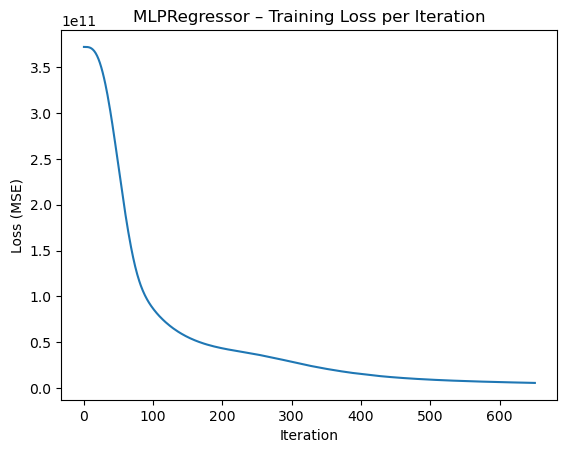

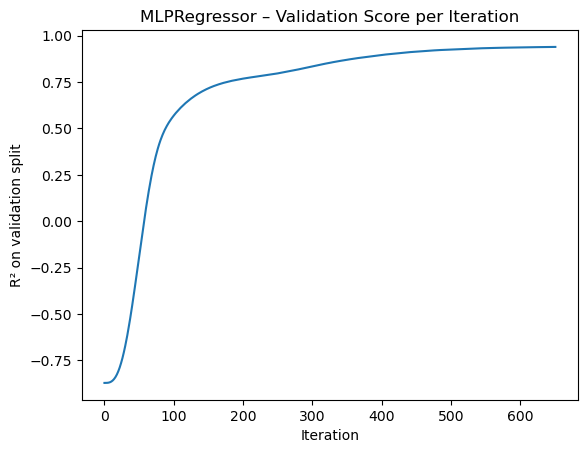

In [6]:
import matplotlib.pyplot as plt

# pull the fitted MLP from the pipeline
mlp_final = mlp_model.named_steps["model"]

# 1) training loss over iterations
plt.figure()
plt.plot(mlp_final.loss_curve_)
plt.title("MLPRegressor – Training Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss (MSE)")
plt.show()

# 2) validation score over iterations (only if early_stopping=True)
if hasattr(mlp_final, "validation_scores_"):
    plt.figure()
    plt.plot(mlp_final.validation_scores_)
    plt.title("MLPRegressor – Validation Score per Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("R² on validation split")
    plt.show()


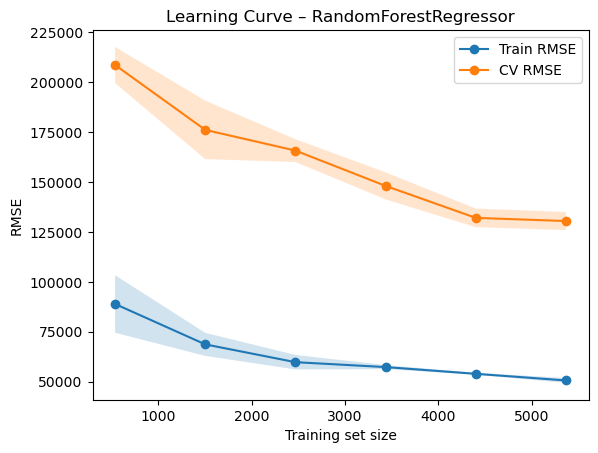

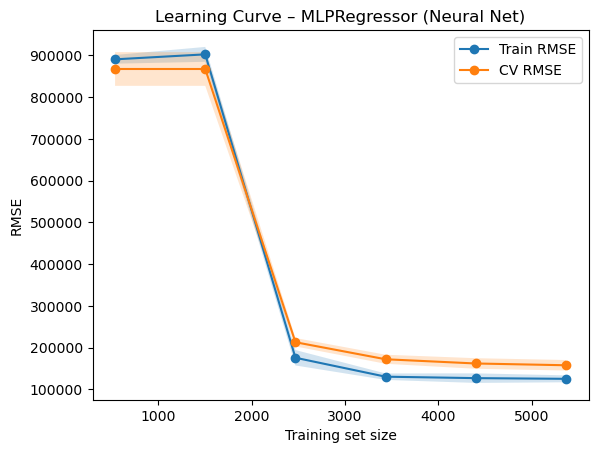

In [7]:
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator,
        X, y,
        cv=3,
        scoring="neg_root_mean_squared_error",  # lower = better
        n_jobs=-1,
        shuffle=True,
        train_sizes=np.linspace(0.1, 1.0, 6),
        random_state=42
    )
    # convert to positive RMSE
    train_rmse = -train_scores
    val_rmse   = -val_scores

    plt.figure()
    plt.plot(train_sizes, train_rmse.mean(axis=1), marker="o", label="Train RMSE")
    plt.plot(train_sizes, val_rmse.mean(axis=1), marker="o", label="CV RMSE")
    plt.fill_between(
        train_sizes,
        train_rmse.mean(axis=1) - train_rmse.std(axis=1),
        train_rmse.mean(axis=1) + train_rmse.std(axis=1),
        alpha=0.2
    )
    plt.fill_between(
        train_sizes,
        val_rmse.mean(axis=1) - val_rmse.std(axis=1),
        val_rmse.mean(axis=1) + val_rmse.std(axis=1),
        alpha=0.2
    )
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

# plot for Random Forest (pipeline) and MLP (pipeline)
plot_learning_curve(rf_model,  X, y, "Learning Curve – RandomForestRegressor")
plot_learning_curve(mlp_model, X, y, "Learning Curve – MLPRegressor (Neural Net)")


=== BASIC STATS (numeric features) ===
       selling_price         year     km_driven  mileage_num    engine_cc  \
count   8.049000e+03  8049.000000  8.049000e+03  7828.000000  7828.000000   
mean    5.893147e+05  2013.755001  7.038344e+04    19.445204  1451.898058   
std     6.376314e+05     4.033145  5.653037e+04     4.037302   500.726595   
min     2.999900e+04  1983.000000  1.000000e+00     0.000000   624.000000   
25%     2.500000e+05  2011.000000  3.500000e+04    16.800000  1197.000000   
50%     4.500000e+05  2015.000000  6.000000e+04    19.330000  1248.000000   
75%     6.600000e+05  2017.000000  1.000000e+05    22.320000  1582.000000   
max     5.200000e+06  2020.000000  2.360457e+06    33.440000  3604.000000   

       max_power_bhp        seats  
count    7833.000000  7828.000000  
mean       90.392159     5.421564  
std        34.026328     0.962491  
min         0.000000     2.000000  
25%        68.050000     5.000000  
50%        82.000000     5.000000  
75%       100.6

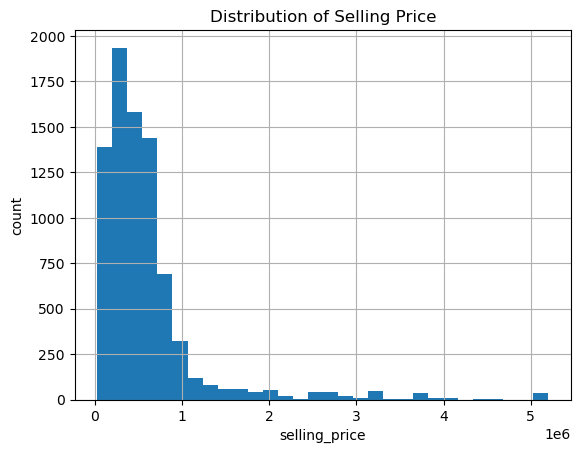

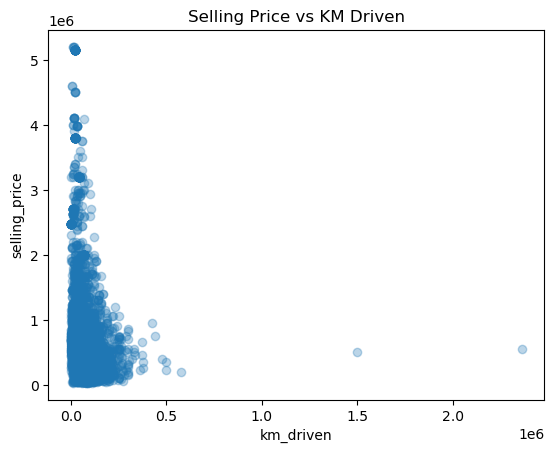

<Figure size 640x480 with 0 Axes>

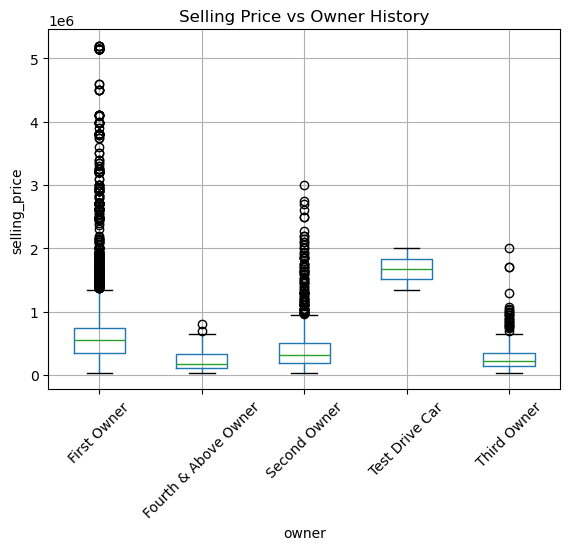

In [8]:
import matplotlib.pyplot as plt

# basic numeric summary: ranges, outliers, etc.
print("=== BASIC STATS (numeric features) ===")
print(df_clean[["selling_price", "year", "km_driven", "mileage_num", "engine_cc", "max_power_bhp", "seats"]].describe())

# category distributions: shows dataset makeup (manual vs auto, fuel types, etc.)
print("\n=== FUEL TYPE COUNTS ===")
print(df_clean["fuel"].value_counts())

print("\n=== TRANSMISSION COUNTS ===")
print(df_clean["transmission"].value_counts())

print("\n=== OWNER COUNTS ===")
print(df_clean["owner"].value_counts())


# 1) Histogram of target price
# shows price is skewed (a few very expensive cars)
plt.figure()
df_clean["selling_price"].hist(bins=30)
plt.title("Distribution of Selling Price")
plt.xlabel("selling_price")
plt.ylabel("count")
plt.show()

# 2) Scatter: km_driven vs selling_price
# cars with very high mileage usually sell cheaper
plt.figure()
plt.scatter(df_clean["km_driven"], df_clean["selling_price"], alpha=0.3)
plt.title("Selling Price vs KM Driven")
plt.xlabel("km_driven")
plt.ylabel("selling_price")
plt.show()

# 3) Boxplot: selling_price by owner type
# first-owner cars usually keep higher value than 3rd/4th owner
plt.figure()
df_clean.boxplot(column="selling_price", by="owner", rot=45)
plt.title("Selling Price vs Owner History")
plt.suptitle("")  # remove auto title
plt.xlabel("owner")
plt.ylabel("selling_price")
plt.show()


Correlation matrix (numeric features):


,selling_price,year,km_driven,mileage_num,engine_cc,max_power_bhp,seats
selling_price,1.000000,0.434726,-0.209866,-0.114886,0.479993,0.741822,0.092670
year,0.434726,1.000000,-0.410737,0.341895,0.002977,0.200764,-0.003195
km_driven,-0.209866,-0.410737,1.000000,-0.181427,0.222098,-0.008314,0.224185
mileage_num,-0.114886,0.341895,-0.181427,1.000000,-0.575615,-0.380417,-0.457439
engine_cc,0.479993,0.002977,0.222098,-0.575615,1.000000,0.704100,0.626172
max_power_bhp,0.741822,0.200764,-0.008314,-0.380417,0.704100,1.000000,0.221964
seats,0.092670,-0.003195,0.224185,-0.457439,0.626172,0.221964,1.000000


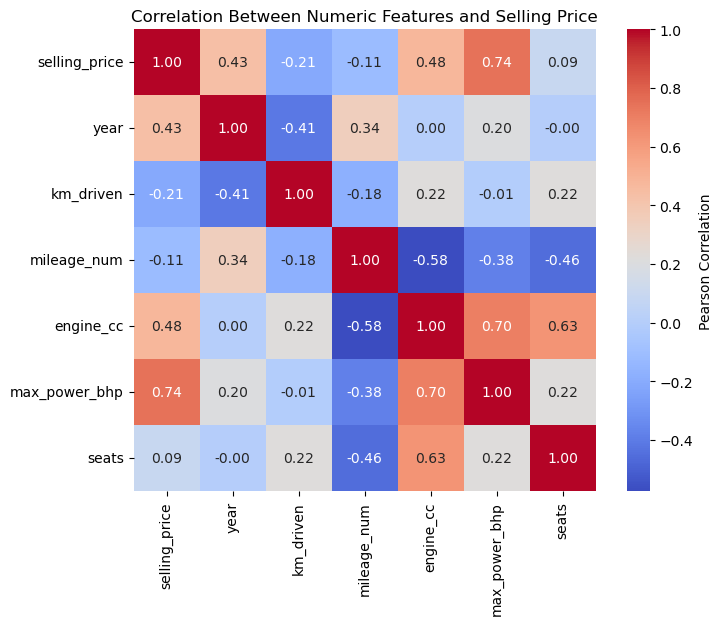


Correlation with selling_price (descending):
selling_price    1.000000
max_power_bhp    0.741822
engine_cc        0.479993
year             0.434726
seats            0.092670
mileage_num     -0.114886
km_driven       -0.209866
Name: selling_price, dtype: float64


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # if seaborn is not installed, you can `pip install seaborn`

# pick only numeric columns we care about
num_cols_for_corr = [
    "selling_price",
    "year",
    "km_driven",
    "mileage_num",
    "engine_cc",
    "max_power_bhp",
    "seats"
]

corr_df = df_clean[num_cols_for_corr].corr(method="pearson")

print("Correlation matrix (numeric features):")
display(corr_df)

# heatmap for visual explanation
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"label": "Pearson Correlation"}
)
plt.title("Correlation Between Numeric Features and Selling Price")
plt.show()

# also: sort features by correlation with price, just to talk about it
target_corr = corr_df["selling_price"].sort_values(ascending=False)
print("\nCorrelation with selling_price (descending):")
print(target_corr)


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model
rf_base = RandomForestRegressor(random_state=42)

# Wider search space
param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5],
}

# Pipeline (same preprocess)
rf_pipeline = Pipeline(steps=[
    ("prep", preprocess),
    ("model", rf_base),
])

# Grid search (optimize RMSE)
grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    refit=True,  # refit on full train with the best params
)

grid.fit(X_train, y_train)

best_params = grid.best_params_
best_cv_rmse = -grid.best_score_  # flip sign to get positive RMSE

print("Best params:", best_params)
print(f"Best CV RMSE: {best_cv_rmse:.4f}")

# Evaluate on TEST
best_rf_model = grid.best_estimator_
y_pred = best_rf_model.predict(X_test)

test_mae  = mean_absolute_error(y_test, y_pred)
test_mse  = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2   = r2_score(y_test, y_pred)

print("\n=== TUNED RANDOM FOREST ON TEST ===")
print(f"MAE : {test_mae:.4f}")
print(f"MSE : {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R^2 : {test_r2:.4f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best params: {'model__max_depth': 30, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best CV RMSE: 135116.5073

=== TUNED RANDOM FOREST ON TEST ===
MAE : 66844.7962
MSE : 17144425631.8852
RMSE: 130936.7238
R^2 : 0.9621


In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- Base MLP (deep / neural) -------------------------------------------------
mlp_base = MLPRegressor(
    max_iter=1000,          # allow more iterations so it can converge
    early_stopping=True,    # stop when validation stops improving
    random_state=42
)

# --- Pipeline: same preprocessing + model -------------------------------------
mlp_pipeline = Pipeline(steps=[
    ("prep", preprocess),   # impute, scale numeric, one-hot encode categoricals
    ("model", mlp_base)
])

# --- Hyperparameter grid for the neural net -----------------------------------
# - hidden_layer_sizes: neurons per layer
# - alpha: L2 regularization
# - learning_rate_init: Adam step size
param_grid_mlp = {
    "model__hidden_layer_sizes": [
        (64, 64),
        (128, 64),
    ],
    "model__alpha": [1e-4, 1e-3],
    "model__learning_rate_init": [1e-3, 5e-4],
}

mlp_grid = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid_mlp,
    cv=3,
    scoring="neg_root_mean_squared_error",  # lower RMSE is better
    n_jobs=-1
)

# --- Fit on TRAIN only ---------------------------------------------------------
mlp_grid.fit(X_train, y_train)

print("Best MLP params:", mlp_grid.best_params_)
print("Best MLP CV score (neg RMSE):", mlp_grid.best_score_)

# --- Best tuned model ----------------------------------------------------------
best_mlp_model = mlp_grid.best_estimator_

# --- Predict on TEST and compute metrics --------------------------------------
best_mlp_pred = best_mlp_model.predict(X_test)

best_mlp_mae  = mean_absolute_error(y_test, best_mlp_pred)
best_mlp_mse  = mean_squared_error(y_test, best_mlp_pred)
best_mlp_rmse = np.sqrt(best_mlp_mse)
best_mlp_r2   = r2_score(y_test, best_mlp_pred)

print("\n=== TUNED MLP REGRESSOR (Neural Net) ON TEST ===")
print("MAE :", best_mlp_mae)
print("MSE :", best_mlp_mse)
print("RMSE:", best_mlp_rmse)
print("R^2 :", best_mlp_r2)


Best MLP params: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (64, 64), 'model__learning_rate_init': 0.001}
Best MLP CV score (neg RMSE): -157783.0803270899

=== TUNED MLP REGRESSOR (Neural Net) ON TEST ===
MAE : 85356.76338650244
MSE : 31216940912.384914
RMSE: 176683.16533383963
R^2 : 0.9310575288398109


In [11]:
# 1. grab the preprocessing step from the tuned model
best_prep = best_rf_model.named_steps["prep"]
best_rf   = best_rf_model.named_steps["model"]

# 2. get the names of numeric features (they pass through as-is after scaler)
num_feature_names = numeric_cols  # already a list

# 3. get the names of the one-hot encoded categorical features
# OneHotEncoder is inside the ColumnTransformer under name "cat"
ohe = best_prep.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

# 4. combine them in the same order ColumnTransformer outputs them
all_feature_names = list(num_feature_names) + list(cat_feature_names)

# 5. get feature importances from the Random Forest
importances = best_rf.feature_importances_

# 6. put into a sorted table
feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("Top 15 most important features:")
display(feat_imp.head(15))


Top 15 most important features:


,feature,importance
4,max_power_bhp,0.659139
0,year,0.139019
1,km_driven,0.065432
747,name_Lexus ES 300h,0.052750
2,mileage_num,0.021981
3,engine_cc,0.018368
1893,transmission_Manual,0.002752
746,name_Land Rover Discovery Sport TD4 SE,0.002694
1892,transmission_Automatic,0.002660
5,seats,0.002598
